<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/m06-centrality/exercise-m06-centrality.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Computing centrality with Python

## Network of university students

Let's compute the centrality of the network using Python igraph.

In [2]:
# Uncomment if you use Colab
# !sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo cairocffi
# !pip install igraph

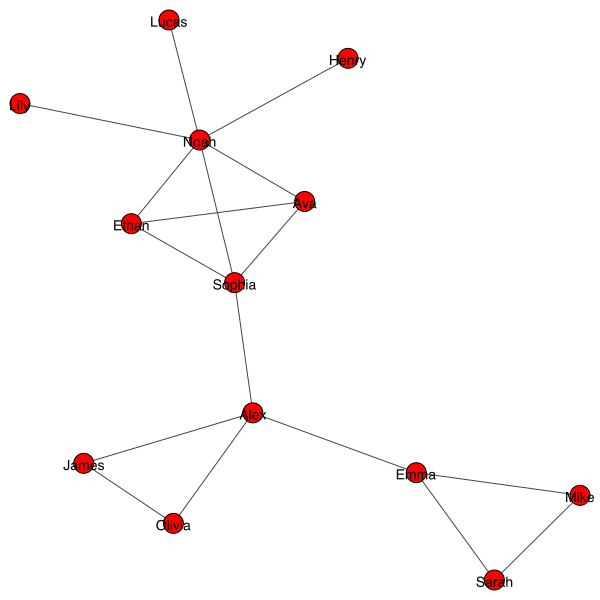

In [1]:
import igraph
import numpy as np

names = [
    "Sarah",
    "Mike",
    "Emma",
    "Alex",
    "Olivia",
    "James",
    "Sophia",
    "Ethan",
    "Ava",
    "Noah",
    "Lily",
    "Lucas",
    "Henry",
]
edge_list = [
    (0, 1),
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5),
    (3, 6),
    (4, 5),
    (6, 7),
    (6, 8),
    (6, 9),
    (7, 8),
    (7, 9),
    (8, 9),
    (9, 10),
    (9, 11),
    (9, 12),
]
g = igraph.Graph()
g.add_vertices(13)
g.vs["name"] = names
g.add_edges(edge_list)
igraph.plot(g, vertex_label=g.vs["name"])

`igraph` offers a wide range of centrality measures as methods of the `igraph.Graph` class.

- **Degree centrality**: `igraph.Graph.degree()`
- **Closeness centrality**: `igraph.Graph.closeness()`
- **Betweenness centrality**: `igraph.Graph.betweenness()`
- **Harmonic centrality**: `igraph.Graph.harmonic_centrality()`
- **Eccentricity**: `igraph.Graph.eccentricity()`
- **Eigenvector centrality**: `igraph.Graph.eigenvector_centrality()`
- **PageRank centrality**: `igraph.Graph.personalized_pagerank()`

For example, the closeness centrality is computed by

In [2]:
g.betweenness()

[0.0, 0.0, 20.0, 41.0, 0.0, 0.0, 36.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0]

### Computing Katz centrality

Let's compute the Katz centrality without using igraph.
Let us first define the adjacency matrix of the graph

In [5]:
A = g.get_adjacency_sparse()

alpha = 1
beta = 1
c = np.linalg.inv(np.eye(g.vcount()) - alpha * A.T) @ np.ones((g.vcount(), 1)) * beta
c

matrix([[-0.5],
        [-0.5],
        [-1. ],
        [-1. ],
        [ 1. ],
        [ 1. ],
        [-3. ],
        [-2.5],
        [-2.5],
        [ 2. ],
        [ 3. ],
        [ 3. ],
        [ 3. ]])

which is the scipy CSR sparse matrix. The Katz centrality is given by

$$

\mathbf{c} = \beta \mathbf{1} + \alpha \mathbf{A} \mathbf{c}

$$

So, how do we solve this? We can use a linear solver but here we will use a simple method:

1. Initialize $\mathbf{c}$ with a random vector.
2. Compute the right hand side of the equation and update $\mathbf{c}$.
3. Repeat the process until $\mathbf{c}$ converges.

Let's implement this.

In [6]:
import numpy as np

alpha, beta = 0.1, 0.05  # Hyperparameters
n_nodes = g.vcount()  # number of nodes
c = np.random.rand(n_nodes, 1)  # column random vector

for _ in range(100):
    c_next = beta * np.ones((n_nodes, 1)) + alpha * A * c
    if np.linalg.norm(c_next - c) < 1e-6:
        break
    c = c_next
print(c)

[[0.06338729]
 [0.06338729]
 [0.07048541]
 [0.07807916]
 [0.06423106]
 [0.06423106]
 [0.08184303]
 [0.07474491]
 [0.07474491]
 [0.09085931]
 [0.059086  ]
 [0.059086  ]
 [0.059086  ]]


- Does the centrality converge?
- Change the hyperparameter and see how the result changes 😉
If the centrality diverges, think about why it diverges.

### Exercise 01: PageRank centrality

Compute the PageRank centrality of this graph

$$
c_i = \frac{\beta}{N} + (1-\beta) \sum_j \frac{A_{ji}}{d^{\text{out}}_j} c_j
$$

$$
c = \beta \mathbf{1} + (1-\beta) \left(\mathbf{D}^{-1} \mathbf{A}\right)^\top \mathbf{c}
$$
where 

$$
\mathbf{D} = 
\begin{bmatrix}
d^{\text{out}}_1 & 0 & 0 & \cdots & 0 \\
0 & d^{\text{out}}_2 & 0 & \cdots & 0 \\
0 & 0 & d^{\text{out}}_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & d^{\text{out}}_N \\
\end{bmatrix}
$$
is the diagonal matrix of the out-degrees.


In [7]:
import numpy as np

beta = 0.25
deg = np.array(A.sum(axis=1)).flatten()

D = np.diag(deg)
Dinv = np.diag(1.0 / deg)
P = Dinv @ A

n_nodes = g.vcount()  # number of nodes
c = np.random.rand(n_nodes, 1)  # column random vector

for _ in range(100):
    c_next = beta * np.ones((n_nodes, 1)) / n_nodes + (1 - beta) * P.T @ c
    if np.linalg.norm(c_next - c) < 1e-6:
        break
    c = c_next
print(c)

[[0.06645846]
 [0.06645846]
 [0.08922243]
 [0.10745373]
 [0.06300561]
 [0.06300561]
 [0.09953502]
 [0.07844014]
 [0.07844014]
 [0.16749019]
 [0.04016713]
 [0.04016713]
 [0.04016713]]


## Network of ancient Roman roads

### Load the data & construct the network

In [8]:
import pandas as pd

root = "https://raw.githubusercontent.com/skojaku/adv-net-sci/main/data/roman-roads"
node_table = pd.read_csv(f"{root}/node_table.csv")
edge_table = pd.read_csv(f"{root}/edge_table.csv")

The node table:

In [9]:
node_table.head(3)

node_id     lon     lat
0        0  12.506  41.875
1        1  12.470  41.904
2        2  12.471  41.881

The edge table:

In [10]:
edge_table.head(3)

src   trg
0  1785   358
1  1785  1771
2  1771   350

Let's construct a network from the node and edge tables.

In [11]:
import igraph

src, trg = edge_table["src"].values, edge_table["trg"].values
g = igraph.Graph()  # create a graph from the edge list

g.add_vertices(node_table["node_id"].values)
g.add_edges(list(zip(src, trg)))

# Your code here

which looks like this:

In [12]:
coord = list(zip(node_table["lon"].values, -node_table["lat"].values))
igraph.plot(g, layout=coord, vertex_size=5)

In [13]:
import seaborn as sns
import numpy as np

coord = list(zip(node_table["lon"].values, -node_table["lat"].values))

deg = g.betweenness()

palette = sns.color_palette("viridis", as_cmap=True)
igraph.plot(
    g, layout=coord, vertex_size=5, vertex_color=[palette(d / np.max(deg)) for d in deg]
)

### Exercise 02 🏛️

1. Compute the following centrality measures:
    - Degree centrality 🔢
    - Eigenvector centrality
    - PageRank centrality
    - Katz centrality
    - Betweenness centrality
    - Closeness centrality
2. Plot the centrality measures on the map and see in which centrality Rome is the most important node. 🗺️🏛️ (as beautiful as possible!!)


### Exercise 03:

A BCDE graph is a graph where the most central nodes in terms of: 
- (B) Betweenness centrality
- (C) Closeness centrality
- (D) Degree centrality
- (E) Eccentricity

are different. It is known that the smallest number of nodes of a BCDE graph is 10. Surely, it is challenging to find the smallest one. So, let's create a BCDE graph of nodes between 10 and 15 nodes. If possible, identify the smallest BCDE graph. 
